In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/kdef/original/KDEF-HRS-organized421414-cropped16400-occluded')

training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42

In [3]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [4]:
import keras

print('---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=True,
                                                                seed=SEED)

class_frequencies = compute_class_frequencies(training_set_path)


2024-03-20 13:57:15.818936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 13:57:15.840795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 13:57:15.840815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 13:57:15.841354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 13:57:15.845125: I tensorflow/core/platform/cpu_feature_guar

---TRAINING SET---
Found 1175 files belonging to 7 classes.


2024-03-20 13:57:16.755183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 13:57:16.774173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 13:57:16.774292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0 - Neutral   :      167 images
1 - Happy     :      168 images
2 - Sad       :      168 images
3 - Surprise  :      168 images
4 - Fear      :      168 images
5 - Disgust   :      168 images
6 - Anger     :      168 images


In [5]:
print('---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=True,
                                                                  seed=SEED)

compute_class_frequencies(validation_set_path)


---VALIDATION SET---
Found 391 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       55 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images


{0: 56, 1: 56, 2: 56, 3: 55, 4: 56, 5: 56, 6: 56}

In [6]:
total_num_samples = sum(class_frequencies.values())
inverse_class_frequencies = {class_id: 1 / (frequency / total_num_samples) for class_id, frequency in
                             class_frequencies.items()}

total_inverse_class_frequencies = sum(inverse_class_frequencies.values())
class_weights = {class_id: freq / total_inverse_class_frequencies for class_id, freq in
                 inverse_class_frequencies.items()}

print(class_weights)

{0: 0.14358974358974358, 1: 0.1427350427350427, 2: 0.1427350427350427, 3: 0.1427350427350427, 4: 0.1427350427350427, 5: 0.1427350427350427, 6: 0.1427350427350427}


In [7]:
from keras import layers
from keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode="constant"),
    layers.RandomRotation(0.1, fill_mode="constant"),
    layers.RandomZoom(0.1, fill_mode="constant"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
x = data_augmentation(inputs)


In [8]:
from keras.src.applications import EfficientNetB0


def build_model(num_classes, inputs_layer):
    model = EfficientNetB0(include_top=False, input_tensor=inputs_layer, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(0.2, name="top_dropout1")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    return keras.Model(inputs, outputs, name="EfficientNet")


model = build_model(len(class_frequencies), x)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                   

In [9]:
num_layers = len(model.layers)
for i, layer in enumerate(model.layers):
    print((num_layers - i), layer.name, layer.__class__.__name__)

242 input_1 InputLayer
241 sequential Sequential
240 rescaling Rescaling
239 normalization Normalization
238 rescaling_1 Rescaling
237 stem_conv_pad ZeroPadding2D
236 stem_conv Conv2D
235 stem_bn BatchNormalization
234 stem_activation Activation
233 block1a_dwconv DepthwiseConv2D
232 block1a_bn BatchNormalization
231 block1a_activation Activation
230 block1a_se_squeeze GlobalAveragePooling2D
229 block1a_se_reshape Reshape
228 block1a_se_reduce Conv2D
227 block1a_se_expand Conv2D
226 block1a_se_excite Multiply
225 block1a_project_conv Conv2D
224 block1a_project_bn BatchNormalization
223 block2a_expand_conv Conv2D
222 block2a_expand_bn BatchNormalization
221 block2a_expand_activation Activation
220 block2a_dwconv_pad ZeroPadding2D
219 block2a_dwconv DepthwiseConv2D
218 block2a_bn BatchNormalization
217 block2a_activation Activation
216 block2a_se_squeeze GlobalAveragePooling2D
215 block2a_se_reshape Reshape
214 block2a_se_reduce Conv2D
213 block2a_se_expand Conv2D
212 block2a_se_excite M

In [10]:
def unfreeze_model(model, num_layers):
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [11]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f"kdef_occluded_transfer_imagenet_{timestamp}")
training_histories = []
epoch_counter = 0
epochs_per_phase = [8, 8, 8, 8, 8, 8, 8, 12, 20]
layers_to_unfreeze_per_phase = [3, 19, 78, 121, 165, 194, 223, len(model.layers), len(model.layers)]
learning_rate_per_phase = [1e-3, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-5]

for phase, (epochs, layers_to_unfreeze, learning_rate) in enumerate(
        zip(epochs_per_phase, layers_to_unfreeze_per_phase, learning_rate_per_phase)):

    print(f'\n---STARTING TRAINING PHASE {phase}')
    print(f'EPOCHS:{epochs} LAYERS_TO_UNFREEZE:{layers_to_unfreeze} LEARNING_RATE:{learning_rate}')
    checkpoint_filepath = str(checkpoint_dir / f'best_model_phase_{phase}.keras')

    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=False,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True)

    if phase > 0:
        old_checkpoint_filepath = checkpoint_filepath.replace(f'phase_{phase}', f'phase_{phase - 1}')
        print(f'Loading model from {old_checkpoint_filepath}')
        model = load_model(old_checkpoint_filepath)

    unfreeze_model(model, layers_to_unfreeze)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    hist = model.fit(training_set,
                     epochs=epoch_counter + epochs,
                     validation_data=validation_set,
                     class_weight=class_weights,
                     callbacks=[model_checkpoint_callback],
                     initial_epoch=epoch_counter)

    epoch_counter += epochs
    training_histories.append(hist)


---STARTING TRAINING PHASE 0
EPOCHS:8 LAYERS_TO_UNFREEZE:3 LEARNING_RATE:0.001
Epoch 1/8


2024-03-20 13:57:24.270401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 13:57:24.341377: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 3/37 [=>............................] - ETA: 1s - loss: 0.2780 - accuracy: 0.1458  

2024-03-20 13:57:25.074292: I external/local_xla/xla/service/service.cc:168] XLA service 0x7700e8f40a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 13:57:25.074308: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-20 13:57:25.077461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710939445.132930   26215 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 8s 69ms/step - loss: 0.2820 - accuracy: 0.1609 - val_loss: 1.8969 - val_accuracy: 0.1867
Epoch 2/8
37/37 [==============================] - 2s 41ms/step - loss: 0.2708 - accuracy: 0.2400 - val_loss: 1.8200 - val_accuracy: 0.2992
Epoch 3/8
37/37 [==============================] - 2s 51ms/step - loss: 0.2626 - accuracy: 0.2715 - val_loss: 1.7853 - val_accuracy: 0.3274
Epoch 4/8
37/37 [==============================] - 2s 41ms/step - loss: 0.2539 - accuracy: 0.3047 - val_loss: 1.7181 - val_accuracy: 0.3325
Epoch 5/8
37/37 [==============================] - 2s 48ms/step - loss: 0.2488 - accuracy: 0.3328 - val_loss: 1.6794 - val_accuracy: 0.4246
Epoch 6/8
37/37 [==============================] - 2s 49ms/step - loss: 0.2424 - accuracy: 0.3677 - val_loss: 1.6423 - val_accuracy: 0.4297
Epoch 7/8
37/37 [==============================] - 2s 44ms/step - loss: 0.2387 - accuracy: 0.3702 - val_loss: 1.6174 - val_accuracy: 0.4578
Epoch 8/8
37/37 [=============

2024-03-20 13:57:45.417744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 8s 71ms/step - loss: 0.2309 - accuracy: 0.3796 - val_loss: 1.5113 - val_accuracy: 0.4578
Epoch 10/16
37/37 [==============================] - 2s 43ms/step - loss: 0.2063 - accuracy: 0.4621 - val_loss: 1.3176 - val_accuracy: 0.5166
Epoch 11/16
37/37 [==============================] - 2s 43ms/step - loss: 0.1908 - accuracy: 0.5021 - val_loss: 1.2300 - val_accuracy: 0.5422
Epoch 12/16
37/37 [==============================] - 2s 42ms/step - loss: 0.1841 - accuracy: 0.5174 - val_loss: 1.1688 - val_accuracy: 0.5703
Epoch 13/16
37/37 [==============================] - 1s 36ms/step - loss: 0.1687 - accuracy: 0.5549 - val_loss: 1.1375 - val_accuracy: 0.5703
Epoch 14/16
37/37 [==============================] - 2s 43ms/step - loss: 0.1661 - accuracy: 0.5600 - val_loss: 1.0974 - val_accuracy: 0.5831
Epoch 15/16
37/37 [==============================] - 2s 42ms/step - loss: 0.1617 - accuracy: 0.5643 - val_loss: 1.0256 - val_accuracy: 0.6317
Epoch 16/16
37/37 

2024-03-20 13:59:03.394927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 12s 82ms/step - loss: 0.0639 - accuracy: 0.8306 - val_loss: 0.6488 - val_accuracy: 0.7673
Epoch 34/40
37/37 [==============================] - 2s 59ms/step - loss: 0.0527 - accuracy: 0.8715 - val_loss: 0.6401 - val_accuracy: 0.7749
Epoch 35/40
37/37 [==============================] - 2s 50ms/step - loss: 0.0515 - accuracy: 0.8621 - val_loss: 0.7340 - val_accuracy: 0.7391
Epoch 36/40
37/37 [==============================] - 2s 50ms/step - loss: 0.0512 - accuracy: 0.8511 - val_loss: 0.7771 - val_accuracy: 0.7442
Epoch 37/40
37/37 [==============================] - 2s 50ms/step - loss: 0.0451 - accuracy: 0.8766 - val_loss: 1.1686 - val_accuracy: 0.6880
Epoch 38/40
37/37 [==============================] - 2s 51ms/step - loss: 0.0481 - accuracy: 0.8740 - val_loss: 0.9088 - val_accuracy: 0.7212
Epoch 39/40
37/37 [==============================] - 3s 70ms/step - loss: 0.0371 - accuracy: 0.8928 - val_loss: 0.6893 - val_accuracy: 0.7775
Epoch 40/40
37/37

2024-03-20 14:00:10.720625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 16s 108ms/step - loss: 0.0389 - accuracy: 0.8911 - val_loss: 0.7270 - val_accuracy: 0.7954
Epoch 50/56
37/37 [==============================] - 3s 85ms/step - loss: 0.0327 - accuracy: 0.9217 - val_loss: 0.7166 - val_accuracy: 0.8031
Epoch 51/56
37/37 [==============================] - 3s 76ms/step - loss: 0.0280 - accuracy: 0.9251 - val_loss: 0.7721 - val_accuracy: 0.7801
Epoch 52/56
37/37 [==============================] - 3s 76ms/step - loss: 0.0257 - accuracy: 0.9379 - val_loss: 0.7459 - val_accuracy: 0.7903
Epoch 53/56
37/37 [==============================] - 3s 76ms/step - loss: 0.0292 - accuracy: 0.9260 - val_loss: 0.7416 - val_accuracy: 0.7852
Epoch 54/56
37/37 [==============================] - 3s 77ms/step - loss: 0.0260 - accuracy: 0.9353 - val_loss: 0.7076 - val_accuracy: 0.7749
Epoch 55/56
37/37 [==============================] - 3s 77ms/step - loss: 0.0232 - accuracy: 0.9438 - val_loss: 0.8484 - val_accuracy: 0.7570
Epoch 56/56
37/3

2024-03-20 14:01:48.758724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 16s 119ms/step - loss: 0.0206 - accuracy: 0.9532 - val_loss: 0.7471 - val_accuracy: 0.7928
Epoch 70/88
37/37 [==============================] - 3s 85ms/step - loss: 0.0180 - accuracy: 0.9498 - val_loss: 0.7250 - val_accuracy: 0.7928
Epoch 71/88
37/37 [==============================] - 3s 84ms/step - loss: 0.0148 - accuracy: 0.9643 - val_loss: 0.7706 - val_accuracy: 0.7877
Epoch 72/88
37/37 [==============================] - 3s 85ms/step - loss: 0.0149 - accuracy: 0.9651 - val_loss: 0.7666 - val_accuracy: 0.7852
Epoch 73/88
37/37 [==============================] - 3s 85ms/step - loss: 0.0137 - accuracy: 0.9694 - val_loss: 0.7902 - val_accuracy: 0.7801
Epoch 74/88
37/37 [==============================] - 4s 94ms/step - loss: 0.0134 - accuracy: 0.9660 - val_loss: 0.7310 - val_accuracy: 0.8005
Epoch 75/88
37/37 [==============================] - 3s 94ms/step - loss: 0.0171 - accuracy: 0.9557 - val_loss: 0.7642 - val_accuracy: 0.8031
Epoch 76/88
37/3

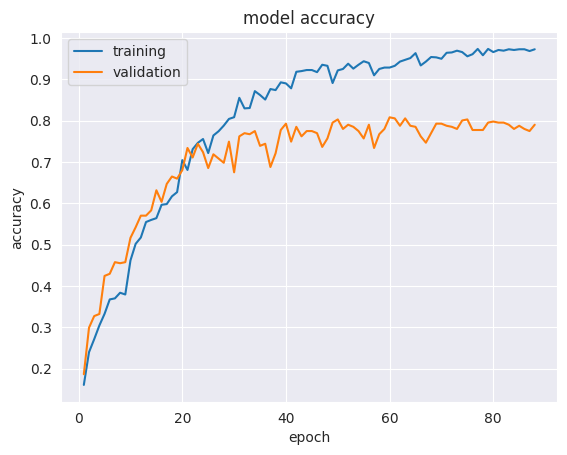

In [12]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hists, checkpoint_dir):
    acc = []
    val_acc = []

    for hist in hists:
        acc += hist.history["accuracy"]
        val_acc += hist.history["val_accuracy"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(training_histories, checkpoint_dir)

In [13]:
import csv


def save_training_history_csv(hists, checkpoint_dir):
    acc = []
    val_acc = []
    for hist in hists:
        acc.extend(hist.history["accuracy"])
        val_acc.extend(hist.history["val_accuracy"])

    epochs = range(1, len(acc) + 1)

    # CSV-Datei schreiben
    with (checkpoint_dir / 'training_history.csv').open(mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'accuracy', 'val_accuracy'])
        for epoch, accuracy, val_accuracy in zip(epochs, acc, val_acc):
            writer.writerow([epoch, accuracy, val_accuracy])


save_training_history_csv(training_histories, checkpoint_dir)

In [21]:
best_checkpoint = str(checkpoint_dir / "best_model_phase_7.keras")
model = load_model(best_checkpoint)

In [22]:
print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)



---TEST SET---
Found 392 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       56 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images


{0: 56, 1: 56, 2: 56, 3: 56, 4: 56, 5: 56, 6: 56}

In [23]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

13/13 [==============================] - 2s 25ms/step - loss: 0.7491 - accuracy: 0.7959
Test accuracy: 0.795918345451355


In [24]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(test_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

13/13 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

     Neutral     0.8519    0.8214    0.8364        56
       Happy     0.9815    0.9464    0.9636        56
         Sad     0.8542    0.7321    0.7885        56
    Surprise     0.7027    0.9286    0.8000        56
        Fear     0.7297    0.4821    0.5806        56
     Disgust     0.7714    0.9643    0.8571        56
       Anger     0.7091    0.6964    0.7027        56

    accuracy                         0.7959       392
   macro avg     0.8001    0.7959    0.7899       392
weighted avg     0.8001    0.7959    0.7899       392


[[46  0  5  1  1  0  3]
 [ 0 53  0  0  3  0  0]
 [ 3  0 41  1  3  7  1]
 [ 0  0  0 52  1  0  3]
 [ 1  1  1 18 27  1  7]
 [ 0  0  0  0  0 54  2]
 [ 4  0  1  2  2  8 39]]


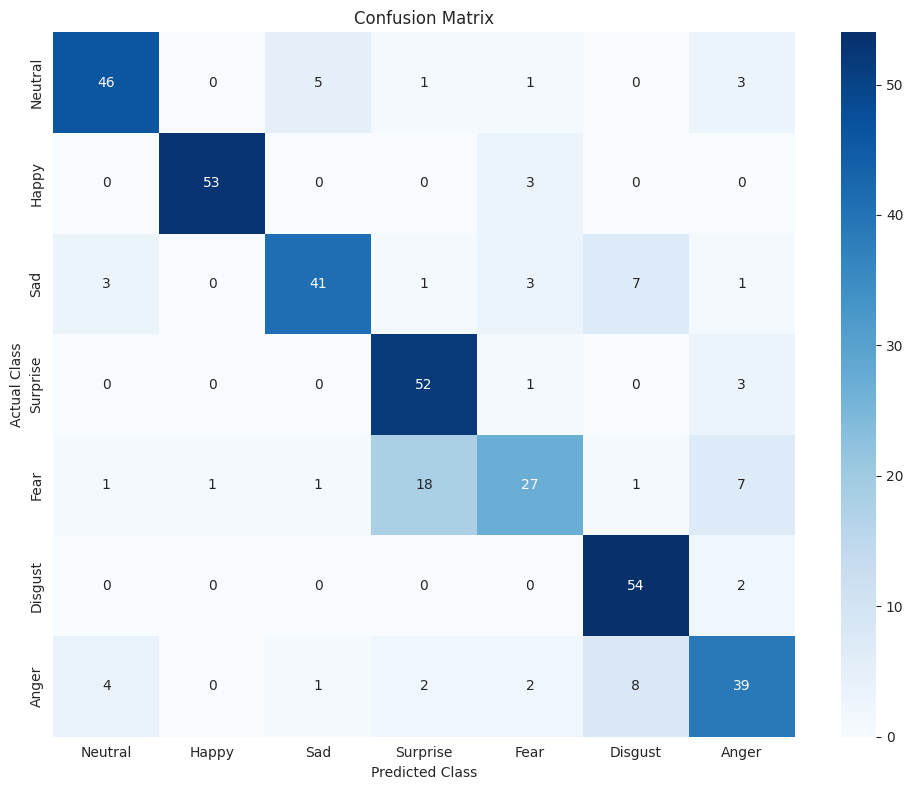

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [26]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [20]:
import shutil

path_to_this_notebook = Path('/home/thor/Desktop/repos/emoji-hero-baseline/kdef_occluded_transfer_imagenet.ipynb')

shutil.copy2(path_to_this_notebook, (checkpoint_dir / path_to_this_notebook.name))

PosixPath('kdef_occluded_transfer_imagenet_20240320-1357/kdef_occluded_transfer_imagenet.ipynb')